# Do-It-Yourself

In [122]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from ipywidgets import interact, fixed

## Task I: AirBnb distribution in Beijing

In this task, you will explore patterns in the distribution of the location of AirBnb properties in Beijing. For that, we will use data from the same provider as we did for the [clustering](../bG/lab_G) block: [Inside AirBnb](http://insideairbnb.com). We are going to read in a file with the locations of the properties available as of August 15th. 2019:



In [84]:
url = (
    "http://data.insideairbnb.com/china/beijing/beijing/"
    "2023-03-29/data/listings.csv.gz"
)
url

'http://data.insideairbnb.com/china/beijing/beijing/2023-03-29/data/listings.csv.gz'


````{margin}
```{admonition} Important
Make sure you are connected to the internet when you run this cell
```
````

In [85]:
abb = pd.read_csv(url)



````{admonition} Alternative
Instead of reading the file directly off the web, it is possible to download it manually, store it on your computer, and read it locally. To do that, you can follow these steps:
1. Download the file by right-clicking on [this link](http://data.insideairbnb.com/china/beijing/beijing/2019-08-15/visualisations/listings.csv) and saving the file
1. Place the file on the _same folder as the notebook_ where you intend to read it
1. Replace the code in the cell above by:
```python
abb = pandas.read_csv("listings.csv")
```
````


---

Note the code cell above requires internet connectivity. If you are not online but have a full copy of the GDS course in your computer (downloaded as suggested in the [infrastructure page](../infrastructure)), you can read the data with the following line of code: 

In [86]:
abb = pd.read_csv("../data/web_cache/abb_listings.csv.zip")

---

This gives us a table with the following information:

In [87]:
abb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21448 entries, 0 to 21447
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              21448 non-null  int64  
 1   name                            21448 non-null  object 
 2   host_id                         21448 non-null  int64  
 3   host_name                       21428 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   21448 non-null  object 
 6   latitude                        21448 non-null  float64
 7   longitude                       21448 non-null  float64
 8   room_type                       21448 non-null  object 
 9   price                           21448 non-null  int64  
 10  minimum_nights                  21448 non-null  int64  
 11  number_of_reviews               21448 non-null  int64  
 12  last_review                     

Also, for an ancillary geography, we will use the neighbourhoods provided by the same source:

In [88]:
url = (
    "http://data.insideairbnb.com/china/beijing/beijing/"
    "2023-03-29/visualisations/neighbourhoods.geojson"
)
url

'http://data.insideairbnb.com/china/beijing/beijing/2023-03-29/visualisations/neighbourhoods.geojson'


````{margin}
```{admonition} Important
Make sure you are connected to the internet when you run this cell
```
````

In [89]:
neis = gpd.read_file(url)



````{admonition} Alternative
Instead of reading the file directly off the web, it is possible to download it manually, store it on your computer, and read it locally. To do that, you can follow these steps:
1. Download the file by right-clicking on [this link](http://data.insideairbnb.com/china/beijing/beijing/2019-08-15/visualisations/neighbourhoods.geojson) and saving the file
1. Place the file on the _same folder as the notebook_ where you intend to read it
1. Replace the code in the cell above by:
```python
neis = geopandas.read_file("neighbourhoods.geojson")
```
````


---

Note the code cell above requires internet connectivity. If you are not online but have a full copy of the GDS course in your computer (downloaded as suggested in the [infrastructure page](../infrastructure)), you can read the data with the following line of code: 

In [90]:
neis = gpd.read_file("../data/web_cache/abb_neis.gpkg")

---

In [91]:
neis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighbourhood        16 non-null     object  
 1   neighbourhood_group  0 non-null      object  
 2   geometry             16 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 512.0+ bytes


With these at hand, get to work with the following challenges:

* Create a Hex binning map of the property locations
* Compute and display a kernel density estimate (KDE) of the distribution of the properties
* Using the neighbourhood layer:
    * Obtain a count of property by neighbourhood (nothe the neighbourhood name is present in the property table and you can connect the two tables through that)
    * Create a raw count choropleth
    * Create a choropleth of the density of properties by polygon
    

## Task I Answers

Hex binning of properties

In [92]:
property_locats = gpd.GeoDataFrame({"geometry":gpd.points_from_xy(x=abb.longitude, y=abb.latitude, crs="EPSG:4326")})

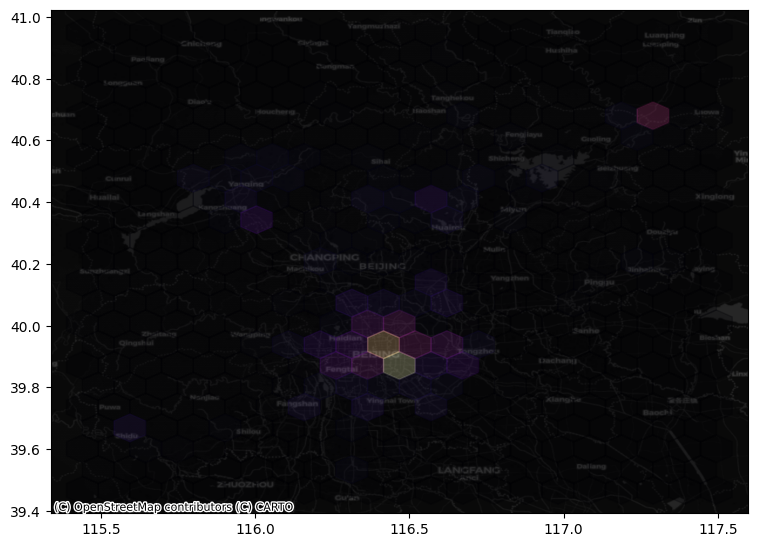

In [93]:
f, ax = plt.subplots(1, figsize=(9,9))
ax.hexbin(
    x=property_locats.geometry.x,
    y=property_locats.geometry.y,
    gridsize=20,
    alpha=0.25,
    cmap="magma"
    )
# property_locats.plot(ax=ax)
cx.add_basemap(ax=ax, crs=property_locats.crs, source=cx.providers.CartoDB.DarkMatter)

KDE plot of locations

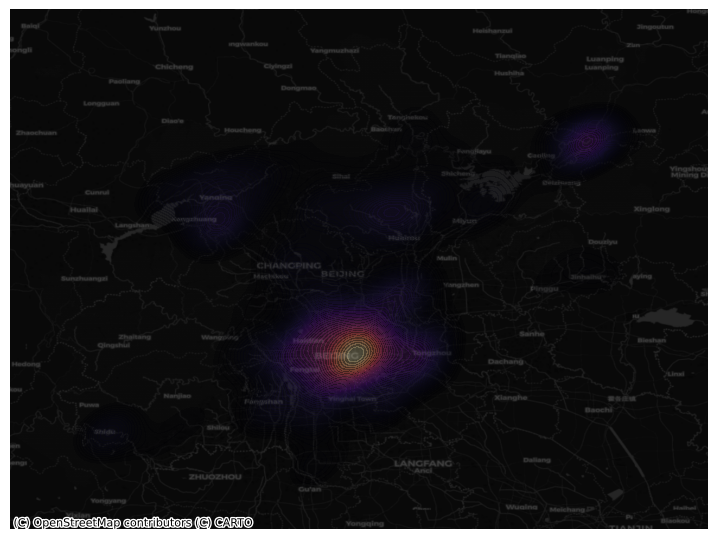

In [94]:
f, ax = plt.subplots(1, figsize=(9,9))
sns.kdeplot(
    x=property_locats.geometry.x,
    y=property_locats.geometry.y,
    n_levels=50,
    fill=True,
    cmap="magma",
    alpha=0.25,
    ax=ax
)
ax.set_axis_off()
cx.add_basemap(ax=ax, crs=property_locats.crs, source=cx.providers.CartoDB.DarkMatter)

Neighborhood analysis

In [95]:
abb_by_nei = abb.groupby('neighbourhood').size()
abbs_by_neis = neis.join(pd.DataFrame({"abb_count":abb_by_nei}), on='neighbourhood')

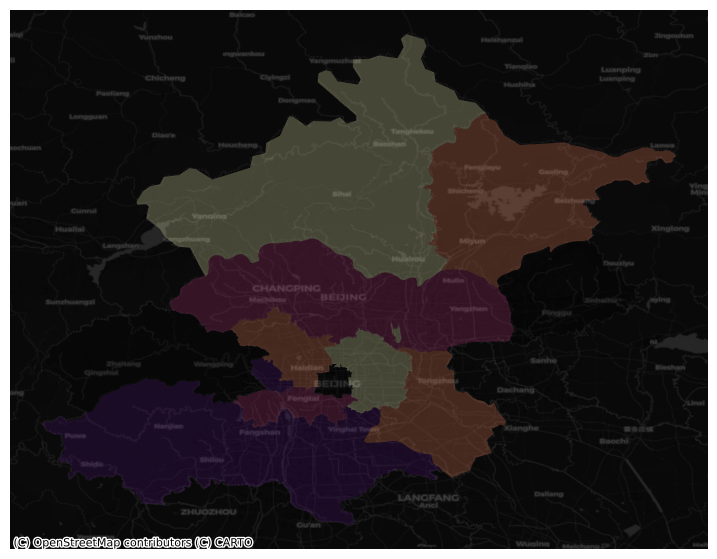

In [96]:
ax = abbs_by_neis.plot(column="abb_count", cmap="magma", alpha=0.25, figsize=(9,9), scheme="quantiles")
ax.set_axis_off()
cx.add_basemap(ax=ax, crs=abbs_by_neis.crs, source=cx.providers.CartoDB.DarkMatter)

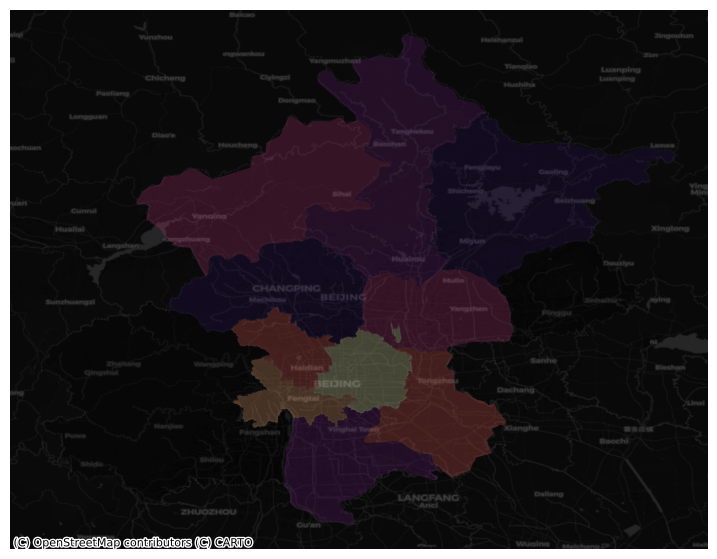

In [114]:
# NOTE: confirmed that this outputs the same as what is in solutions.
# Don't think it matters actually whether you use m or km if you are just comparing the regions to each other
# since the densities end up with the same variance just 1000^2 (because its area) times larger or smaller

abbs_by_neis["abb_density_km2"] = abbs_by_neis["abb_count"] / abbs_by_neis.to_crs(epsg=2459).area

f, ax = plt.subplots(1, figsize=(9,9))
ax.set_axis_off()

abbs_by_neis.plot(
    column="abb_density_km2",
    scheme="quantiles",
    ax=ax,
    cmap="magma",
    alpha=0.25,
    k=7
)
cx.add_basemap(ax=ax, crs=neis.crs, source=cx.providers.CartoDB.DarkMatter)

## Task II: Clusters of Indian cities

For this one, we are going to use a dataset on the location of populated places in India provided by [`http://geojson.xyz`](geojson.xyz). The original table covers the entire world so, to get it ready for you to work on it, we need to prepare it:



In [115]:
url = (
    "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/"
    "ne_50m_populated_places_simple.geojson"
)
url

'https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_populated_places_simple.geojson'



Let's read the file in and keep only places from India:

````{margin}
```{admonition} Important
Make sure you are connected to the internet when you run this cell
```
````

In [118]:
places = gpd.read_file(url).query("adm0name == 'India'")

````{admonition} Alternative
Instead of reading the file directly off the web, it is possible to download it manually, store it on your computer, and read it locally. To do that, you can follow these steps:
1. Download the file by right-clicking on [this link](https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_populated_places_simple.geojson) and saving the file
1. Place the file on the _same folder as the notebook_ where you intend to read it
1. Replace the code in the cell above by:
```python
places = geopandas.read_file("ne_50m_populated_places_simple.geojson")
```
````


---

Note the code cell above requires internet connectivity. If you are not online but have a full copy of the GDS course in your computer (downloaded as suggested in the [infrastructure page](../infrastructure)), you can read the data with the following line of code: 

In [117]:
places = gpd.read_file(
    "../data/web_cache/places.gpkg"
).query("adm0name == 'India'")

---

By default, place locations come expressed in longitude and latitude. Because you will be working with distances, it makes sense to convert the table into a system expressed in metres. For India, this can be the ["Kalianpur 1975 / India zone I"](http://epsg.io/24378) (`EPSG:24378`) projection.

In [119]:
places_m = places.to_crs(epsg=24378)

This is what we have to work with then:

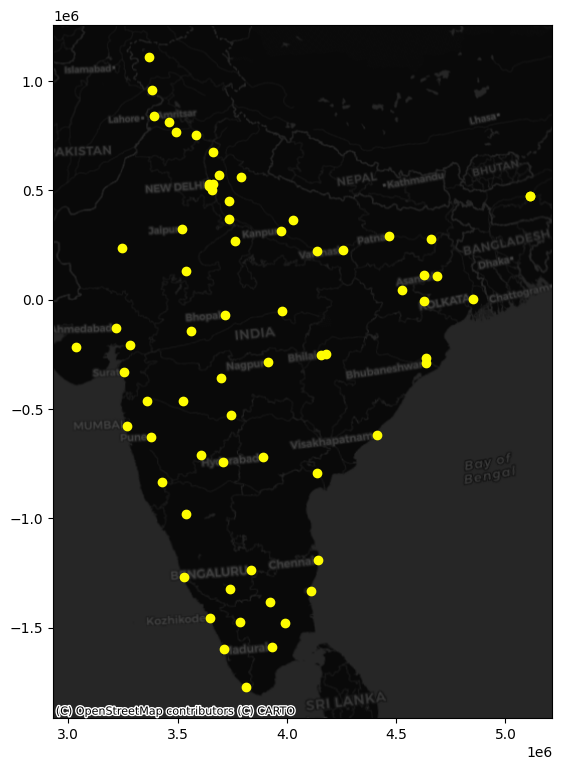

In [120]:
ax = places_m.plot(
    color="xkcd:bright yellow", figsize=(9, 9)
)
cx.add_basemap(
    ax, 
    crs=places_m.crs,
    source=cx.providers.CartoDB.DarkMatter
)

With this at hand, get to work:

- Use the DBSCAN algorithm to identify clusters
- Start with the following parameters: at least five cities for a cluster (`min_samples`) and a maximum of 1,000Km (`eps`)
- Obtain the clusters and plot them on a map. *Does it pick up any interesting pattern?*
- Based on the results above, tweak the values of both parameters to find a cluster of southern cities, and another one of cities in the North around New Dehli

## Task II Answers

In [149]:
places_m["x"] = places_m.geometry.x
places_m["y"] = places_m.geometry.y
def dbscan_plot(data, eps, min_samples):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(data[["x", "y"]])
    data["cluster"] = model.labels_

    f, ax = plt.subplots(1, figsize=(9,9))
    ax.set_axis_off()
    noise = data[data['cluster'] == -1]
    noise.plot(
        ax=ax,
        color="grey"
        )
    not_noise = data[data['cluster'] != -1]
    not_noise.plot(
        ax=ax,
        column="cluster",
        categorical=True
        )
    cx.add_basemap(ax=ax, crs=data.crs, source=cx.providers.CartoDB.DarkMatter)

    return plt.show()

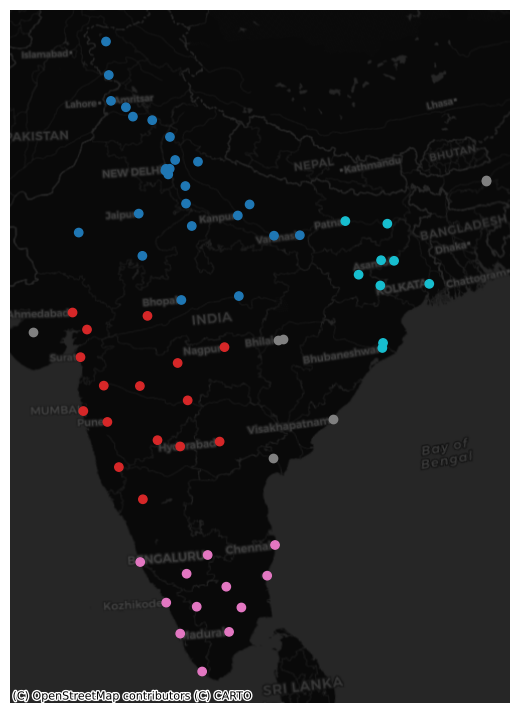

In [158]:
dbscan_plot(places_m, 386000, 10)

In [157]:
interact(
    dbscan_plot,
    data=fixed(places_m),
    eps=(10000,300000,1000),
    min_samples=(1, 10, 1)
)

interactive(children=(IntSlider(value=155000, description='eps', max=300000, min=10000, step=1000), IntSlider(…

<function __main__.dbscan_plot(data, eps, min_samples)>